# Remote Sensing - Exploring Black Marble Imagery at Penn State

## Environment Setup

### Import Packages

In [2]:
# Import packages
import os
import re # in radiance.py
from collections import ChainMap # in radiance.py
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np # in radiance.py
import pandas as pd # in radiance.py
from pandas.io.json import json_normalize # in radiance.py
import rasterio as rio # in radiance.py
from rasterio.plot import plotting_extent
from rasterio.transform import from_origin
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.mask as em # in radiance.py
import radiance as rd

### Set Package Options

In [3]:
# Set options
sns.set(font_scale=1.5)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Define Functions

Defined in `radiance.py`

### Set Working Directory

In [4]:
# Set working directory
working_directory = os.path.join(
    et.io.HOME, "PSU", "08-covid19-remote-sensing-fusion",
    "00-git-repos", "penn-state-radiance")

## Data Preparation

### Define File Paths

In [5]:
# Set path to radiance files
radiance_directory = os.path.join(
    working_directory, "02-raw-data", "PSU_BlackMarble_FallSemester2018_Onwards")

psu_lat_lon_path = os.path.join(
    radiance_directory, "PSU_Pixel_LatLongs.csv")

psu_radiance_path = os.path.join(
    radiance_directory, "PSU_Radiance_RavelOrderF_3.csv")

psu_cloud_mask_path = os.path.join(
    radiance_directory, "PSU_CloudMask_RavelOrderF_3.csv")

In [6]:
# Check that all paths to files exist
for path in [psu_lat_lon_path, psu_radiance_path, psu_cloud_mask_path]:
    print(f"Path exists: {path}") if os.path.exists(
        path) else print(f"Path does not exist: {path}")

Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\PSU_BlackMarble_FallSemester2018_Onwards\PSU_Pixel_LatLongs.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\PSU_BlackMarble_FallSemester2018_Onwards\PSU_Radiance_RavelOrderF_3.csv
Path exists: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\penn-state-radiance\02-raw-data\PSU_BlackMarble_FallSemester2018_Onwards\PSU_CloudMask_RavelOrderF_3.csv


### Read CSV Files to Geodataframes

In [7]:
# Read lat/lon into dataframe
psu_lat_lon_df = pd.read_csv(psu_lat_lon_path)

In [8]:
# Display dataframe
psu_lat_lon_df.head()

,ID,Latitude,Longitude
0,0,40.829917,-77.937355
1,1,40.825751,-77.937355
2,2,40.821584,-77.937355
3,3,40.817417,-77.937355
4,4,40.813251,-77.937355


In [9]:
# Read radiance values to dataframe
psu_radiance_df = pd.read_csv(psu_radiance_path)

In [10]:
psu_radiance_df.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-20,2019-06-21,2019-06-22,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-03,2019-07-04,2019-07-06,2019-07-07,2019-07-08,2019-07-11,2019-07-12,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-31,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-0

In [11]:
# Read cloud mask values to dataframe
psu_cloud_mask_df = pd.read_csv(psu_cloud_mask_path)

In [12]:
psu_cloud_mask_df.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-20,2019-06-21,2019-06-22,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-03,2019-07-04,2019-07-06,2019-07-07,2019-07-08,2019-07-11,2019-07-12,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-31,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-11,2019-09-12,2019-09-13,2019-09-14,2019-09-15,2019-09-17,2019-09-18,2019-0

### Add Missings Dates and Data

Keep it indexed by pixel in order to easily call time series for one pixel. Also add Lat/Lon to it in case there is a need to call based on Lat/Long or to plot with data.

Get a plot with the pixel id in order to more easily call specific pixels or groups of pixels.

Data converted from type *int* to type *float* by within the add missing data function.

In [13]:
# Fill radiance data with missing dates (dates specified by user)
psu_radiance_filled = rd.add_missing_data(
    psu_radiance_df, '2018-09-01', '2020-05-07')

In [14]:
# Display dataset with filled data (NaN)
psu_radiance_filled.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,2019-07-10,2019-07-11,2019-07-12,2019-07-13,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-0

In [15]:
# Fill cloud mask data with missing dates
psu_cloud_mask_filled = rd.add_missing_data(
    psu_cloud_mask_df, '2018-09-01', '2020-05-07')

In [16]:
# Display filled dataset with filled data (NaN)
psu_cloud_mask_filled.head()

,2018-09-01,2018-09-02,2018-09-03,2018-09-04,2018-09-05,2018-09-06,2018-09-07,2018-09-08,2018-09-09,2018-09-10,2018-09-11,2018-09-12,2018-09-13,2018-09-14,2018-09-15,2018-09-16,2018-09-17,2018-09-18,2018-09-19,2018-09-20,2018-09-21,2018-09-22,2018-09-23,2018-09-24,2018-09-25,2018-09-26,2018-09-27,2018-09-28,2018-09-29,2018-09-30,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07,2018-10-08,2018-10-09,2018-10-10,2018-10-11,2018-10-12,2018-10-13,2018-10-14,2018-10-15,2018-10-16,2018-10-17,2018-10-18,2018-10-19,2018-10-20,2018-10-21,2018-10-22,2018-10-23,2018-10-24,2018-10-25,2018-10-26,2018-10-27,2018-10-28,2018-10-29,2018-10-30,2018-10-31,2018-11-01,2018-11-02,2018-11-03,2018-11-04,2018-11-05,2018-11-06,2018-11-07,2018-11-08,2018-11-09,2018-11-10,2018-11-11,2018-11-12,2018-11-13,2018-11-14,2018-11-15,2018-11-16,2018-11-17,2018-11-18,2018-11-19,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01,2018-12-02,2018-12-03,2018-12-04,2018-12-05,2018-12-06,2018-12-07,2018-12-08,2018-12-09,2018-12-10,2018-12-11,2018-12-12,2018-12-13,2018-12-14,2018-12-15,2018-12-16,2018-12-17,2018-12-18,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-23,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29,2018-12-30,2018-12-31,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,2019-01-10,2019-01-11,2019-01-12,2019-01-13,2019-01-14,2019-01-15,2019-01-16,2019-01-17,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,2019-02-05,2019-02-06,2019-02-07,2019-02-08,2019-02-09,2019-02-10,2019-02-11,2019-02-12,2019-02-13,2019-02-14,2019-02-15,2019-02-16,2019-02-17,2019-02-18,2019-02-19,2019-02-20,2019-02-21,2019-02-22,2019-02-23,2019-02-24,2019-02-25,2019-02-26,2019-02-27,2019-02-28,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,2019-03-11,2019-03-12,2019-03-13,2019-03-14,2019-03-15,2019-03-16,2019-03-17,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-23,2019-03-24,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29,2019-03-30,2019-03-31,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,2019-04-11,2019-04-12,2019-04-13,2019-04-14,2019-04-15,2019-04-16,2019-04-17,2019-04-18,2019-04-19,2019-04-20,2019-04-21,2019-04-22,2019-04-23,2019-04-24,2019-04-25,2019-04-26,2019-04-27,2019-04-28,2019-04-29,2019-04-30,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08,2019-05-09,2019-05-10,2019-05-11,2019-05-12,2019-05-13,2019-05-14,2019-05-15,2019-05-16,2019-05-17,2019-05-18,2019-05-19,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-25,2019-05-26,2019-05-27,2019-05-28,2019-05-29,2019-05-30,2019-05-31,2019-06-01,2019-06-02,2019-06-03,2019-06-04,2019-06-05,2019-06-06,2019-06-07,2019-06-08,2019-06-09,2019-06-10,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-15,2019-06-16,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-22,2019-06-23,2019-06-24,2019-06-25,2019-06-26,2019-06-27,2019-06-28,2019-06-29,2019-06-30,2019-07-01,2019-07-02,2019-07-03,2019-07-04,2019-07-05,2019-07-06,2019-07-07,2019-07-08,2019-07-09,2019-07-10,2019-07-11,2019-07-12,2019-07-13,2019-07-14,2019-07-15,2019-07-16,2019-07-17,2019-07-18,2019-07-19,2019-07-20,2019-07-21,2019-07-22,2019-07-23,2019-07-24,2019-07-25,2019-07-26,2019-07-27,2019-07-28,2019-07-29,2019-07-30,2019-07-31,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-0

Is there a way to mask the full dataframe, instead of calling individual months days first? This way, the pre-processing is up front?

Implement something similar to monthly, where user enters date range (radiance and mask data), and the function masks data and stores the masked array in a dictionary?

### Extract Plotting Extent & Transform

In [17]:
# Extract PSU extent and transform from lat/lon dataframe
psu_extent, psu_transform, psu_shape = rd.extract_extent(
    study_area=psu_lat_lon_df, 
    longitude_column='Longitude', 
    latitude_column='Latitude')

In [18]:
# Display extent (left, right, bottom, top)
psu_extent

(-77.93735504, -77.77068837333334, 40.754917322941175, 40.82991733)

In [19]:
# Display tranform (used for export)
psu_transform

Affine(0.004166666666666521, 0.0, -77.93735504,
       0.0, -0.004166667058823534, 40.82991733)

In [20]:
# Display shape
psu_shape

(18, 40)

### Create GeoDataFrame of Lat/Lon Points

In [21]:
# Create geodataframe to store lat/lon points 
#  (for plotting over array)
psu_lat_lon_copy = psu_lat_lon_df.copy()

psu_lat_lon_gdf = gpd.GeoDataFrame(
    psu_lat_lon_copy, 
    crs="epsg:4326", 
    geometry=gpd.points_from_xy(
        psu_lat_lon_copy.Longitude, 
        psu_lat_lon_copy.Latitude)
)

In [22]:
# Display dataframe
psu_lat_lon_gdf.head()

,ID,Latitude,Longitude,geometry
0,0,40.829917,-77.937355,POINT (-77.93736 40.82992)
1,1,40.825751,-77.937355,POINT (-77.93736 40.82575)
2,2,40.821584,-77.937355,POINT (-77.93736 40.82158)
3,3,40.817417,-77.937355,POINT (-77.93736 40.81742)
4,4,40.813251,-77.937355,POINT (-77.93736 40.81325)


## Data Processing

### Plot Single-Pixel Radiance Values

In [ ]:
# # Get radiance data for one pixel (Sept 2019 - April 2020)
# pixel_id_0_radiance = psu_radiance_filled.loc[0]

In [ ]:
# # Get cloud mask data for one pixel (Sept 2019 - April 2020)
# pixel_id_0_mask = psu_cloud_mask_filled.loc[[0]]

In [ ]:
# # Plot single-pixel time series
# with plt.style.context('dark_background'):
    
#     ax = pixel_id_0_radiance.plot(figsize=(16,6), grid=False, color='#ff7f00', linewidth=2)
    
#     ax.set_title('Penn State Campus - Single-Pixel Time Series\nPixel ID 0 - Longitude: -77.937355, Latitude: 40.829917')
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Unmasked Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)')

### Store Daily Radiance Values

In [23]:
# Get list of dates (daily) from Sept 1, 2018 to May 7, 2020
date_list = rd.create_date_list(start_date='2018-09-01', end_date='2020-05-07')

In [24]:
# Display number of days in list
len(date_list)

615

In [25]:
# Store all daily filled values in nested dictionary
#  (indexed by [Year][Month][Day])
radiance_sept_2018_may_2020 = rd.store_data(
    psu_radiance_filled, psu_cloud_mask_filled, 
    mask_value=100, array_shape=psu_shape, dates=date_list)

In [26]:
# Initialize counters for years/months/days in dictionary
years = months = days = 0
radiance_dict = radiance_sept_2018_may_2020

# Loop through all years
for key_year in radiance_dict.keys():

    # Add to counter for each year
    years += 1
    
    # Loop through all months
    for key_month in radiance_dict.get(key_year).keys():
        
        # Add to counter for each month
        months += 1
        
        # Loop through all days
        for key_day in radiance_dict.get(key_year).get(key_month):
        
            # Add to counter for each day
            days += 1

In [27]:
# Display number of years/months/days in dictionary
print(f"Entries in Radiance Dictionary\nYears:    {years}\nMonths:  {months}\nDays:   {days}")

Entries in Radiance Dictionary
Years:    3
Months:  21
Days:   615


### Calculate and Store Radiance Means

Function to calculate means for date range

One function explicitly for monthly means (direct call to dictionary).

One function for date ranges (continuous).

One function for date ranges (non-continuous).


Then combine the functionality with parameters.

aggregation_monthly=True, continuous_range=None
if aggregation_level:
    * follow direct dictionary routine

else:
    * if continuous_range=True:
        * follow continuous range routine
    * else:
        * follow non-continuous range routine

store monthly means (direct dictionary call)

**PSU Academic Calendars**

http://www.registrar.psu.edu/academic-calendars/

http://www.registrar.psu.edu/academic-calendars/2018-19.cfm

http://www.registrar.psu.edu/academic-calendars/2019-20.cfm

### Date Range Radiance Mean - Monthly Radiance

In [44]:
# Define year/month tuples to loop through
calendar_months_2018_2020 = [
    '2018-09',
    '2018-10',
    '2018-11',
    '2018-12',
    '2019-01',
    '2019-02',
    '2019-03',
    '2019-04',
    '2019-05',
    '2019-06',
    '2019-07',
    '2019-08',
    '2019-09',
    '2019-10',
    '2019-11',
    '2019-12',
    '2020-01',
    '2020-02',
    '2020-03',
    '2020-04'
]

In [45]:
# Store monthly means in dictionary
radiance_monthtly_mean = rd.store_monthly_mean(
    radiance_daily=radiance_sept_2018_may_2020, 
    dates=calendar_months_2018_2020)

In [46]:
# Show top-level keys (years)
radiance_monthtly_mean.keys()

dict_keys(['2018', '2019', '2020'])

In [47]:
# Show 2018 keys (months)
radiance_monthtly_mean.get('2018').keys()

dict_keys(['09', '10', '11', '12'])

In [48]:
# Show 2019 keys (months)
radiance_monthtly_mean.get('2019').keys()

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

In [49]:
# Show 2020 keys (months)
radiance_monthtly_mean.get('2020').keys()

dict_keys(['01', '02', '03', '04'])

In [50]:
# Get min and max values for September 2019 mean
print(f"Min Radiance, Sept 2019 Mean Values: {radiance_monthtly_mean.get('2019').get('09').min()}")
print(f"Max Radiance, Sept 2019 Mean Values: {radiance_monthtly_mean.get('2019').get('09').max()}")

Min Radiance, Sept 2019 Mean Values: 21.565217391304348
Max Radiance, Sept 2019 Mean Values: 611.1739130434783


In [51]:
# Get min and max values for March 2020 mean
print(f"Min Radiance, March 2020 Mean Values: {radiance_monthtly_mean.get('2020').get('03').min()}")
print(f"Max Radiance, March 2020 Mean Values: {radiance_monthtly_mean.get('2020').get('03').max()}")

Min Radiance, March 2020 Mean Values: 21.741935483870968
Max Radiance, March 2020 Mean Values: 430.03225806451616


In [54]:
# # Calculate Sept 2019 to March 2020 difference
# diff_sept_2019_march_2020 = rd.subtract_arrays(
#     radiance_monthtly_mean.get('2020').get('03'),
#     radiance_monthtly_mean.get('2019').get('09'))

# # Plot difference from Sept 2019 to March 2020
# ep.plot_bands(
#     diff_sept_2019_march_2020, 
#     scale=False, 
#     vmin=diff_sept_2019_march_2020.min(),
#     vmax=-diff_sept_2019_march_2020.min(),
#     cmap='RdBu_r',
#     figsize=(16, 8))

# plt.show()

### Date Range Radiance Mean - Continuous Date Ranges

In [38]:
# Define date ranges (start date, end date) to loop through
academic_years_2018_2020 = [
       
    # Labor day weekend to commencement weekend (includes day after commencement)
    ('2018-09-01', '2018-12-16'),
    
    # Thanksgiving holiday
    ('2018-11-18', '2018-11-24'),
    
    # Fall study days & final exam week
    ('2018-12-08', '2018-12-14'),
    
    # After Fall commencement to before Spring new student arrival
    ('2018-12-17', '2019-01-04'),
    
    # Spring new student arrival to Spring commencement (commencement weekend)
    ('2019-01-05', '2019-05-05'),
    
    # Spring break
    ('2019-03-03', '2019-03-09'),
    
    # Spring study days & final exam week
    ('2019-04-27', '2019-05-03'),
    
    # Maymester (excluding arrival day, which occurs on Spring commencement)
    ('2019-05-06', '2019-06-05'),
    
    # Summer session (regular) through commencement (includes day after commencement)
    ('2019-05-12', '2019-08-11'),
    
    
    # 2019-2020 academic year
    # Fall new student arrival to commencement weekend (includes day after commencement)
    ('2019-08-23', '2019-12-22'),
    
    # Labor day weekend to Commencement weekend (includes day after commencement)
    ('2019-08-31', '2019-12-22'),
        
    # Thanksgiving holiday
    ('2019-11-24', '2019-11-30'),
    
    # Fall study days & final exam week
    ('2019-12-14', '2019-12-20'),
    
    # After Fall commencement to before Spring new student arrival
    ('2019-12-23', '2020-01-10'),
    
    # Spring new student arrival to Spring commencement (commencement weekend)
    ('2020-01-11', '2020-05-10'),
    
    # Spring break
    ('2020-03-08', '2020-03-14'),
    
    # Spring study days & final exam week
    ('2020-05-02', '2020-05-08')
    
#     # Maymester (excluding arrival day, which occurs on Spring commencement)
#     rd.create_date_list('2020-05-11', '2020-06-10'),
    
#     # Summer session (regular) through commencement (includes day after commencement)
#     rd.create_date_list('2020-05-18', '2020-08-15')
]

In [39]:
# Store continuous ranges means in dictionary
academic_years_2018_2020_means = rd.store_continuous_range_mean(
    radiance_daily=radiance_sept_2018_may_2020,
    date_range_list=academic_years_2018_2020)

In [40]:
# Show all keys in dictionary
for key in academic_years_2018_2020_means.keys():
    print(key)

20180901-20181216
20181118-20181124
20181208-20181214
20181217-20190104
20190105-20190505
20190303-20190309
20190427-20190503
20190506-20190605
20190512-20190811
20190823-20191222
20190831-20191222
20191124-20191130
20191214-20191220
20191223-20200110
20200111-20200510
20200308-20200314
20200502-20200508


In [41]:
# Display number of keys
len(academic_years_2018_2020_means.keys())

17

In [42]:
# Display shape of single mean array in dictionary
academic_years_2018_2020_means.get('20190512-20190811').shape

(18, 40)

### Date Range Radiance Mean - Recurring Weekly Days (SUN, MON, TUE, etc.)

In [29]:
# Define date ranges for academic semesters
semester_ranges = [
    
    # Fall 2018
    ('2018-09-01', '2018-12-16'),
    
    # Spring 2019
    ('2019-01-05', '2019-05-05'),

    # Summer 2019
    ('2019-05-12', '2019-08-11'),
    
    # Fall 2019
    ('2019-08-31', '2019-12-22'),
    
    # Spring 2020
    ('2020-01-11', '2020-05-10')
]

In [31]:
# Create list of dictionaries with stored semester weekly radiances
semesters_weekly = [rd.store_weekly_range_mean(radiance_sept_2018_may_2020, start_date, end_date)
                    for start_date, end_date in semester_ranges]

In [34]:
# Unpack list of dictionaries to single dictionary
semesters_unpacked = rd.unpack_dictionaries(semesters_weekly)

# Display all keys in unpacked dictionary
for key in semesters_unpacked.keys():
    print(key)

20180901-20181216-SUN
20180901-20181216-MON
20180901-20181216-TUE
20180901-20181216-WED
20180901-20181216-THU
20180901-20181216-FRI
20180901-20181216-SAT
20180901-20181216-BUS
20190105-20190505-SUN
20190105-20190505-MON
20190105-20190505-TUE
20190105-20190505-WED
20190105-20190505-THU
20190105-20190505-FRI
20190105-20190505-SAT
20190105-20190505-BUS
20190512-20190811-SUN
20190512-20190811-MON
20190512-20190811-TUE
20190512-20190811-WED
20190512-20190811-THU
20190512-20190811-FRI
20190512-20190811-SAT
20190512-20190811-BUS
20190831-20191222-SUN
20190831-20191222-MON
20190831-20191222-TUE
20190831-20191222-WED
20190831-20191222-THU
20190831-20191222-FRI
20190831-20191222-SAT
20190831-20191222-BUS
20200111-20200510-SUN
20200111-20200510-MON
20200111-20200510-TUE
20200111-20200510-WED
20200111-20200510-THU
20200111-20200510-FRI
20200111-20200510-SAT
20200111-20200510-BUS


In [35]:
# Display number of keys
len(semesters_unpacked.keys())

40

In [37]:
# Display shape of single mean array in dictionary
semesters_unpacked.get('20190831-20191222-MON').shape

(18, 40)

## Plot Functions

def plot_values

def plot_histogram (of single array or mean, or change)


In [98]:
def plot_values(radiance, difference=False):
    """Plots the values in a radiance array.

    Parameters
    ----------
    radiance : numpy array
        Array containing raw values, mean values,
        or difference values.

    difference : bool, optional
        Boolean indicating if the array contains raw 
        values or mean values (False) or contains
        difference values (True). Default value is False.

    Returns
    -------
    ax : matplotlib.axes._subplots.AxesSubplot object
        The axes object associated with the plot.

    Example
    -------
        >>>
        >>>
        >>>
    """
    # Find absolute values for radiance min & max
    radiance_min_abs = np.absolute(radiance.min())
    radiance_max_abs = np.absolute(radiance.max())

    # Determine max value (for plotting vmin/vmax)
    plot_max = radiance_min_abs if (
        radiance_min_abs > radiance_max_abs) else radiance_max_abs

    # Use dark background
    with plt.style.context('dark_background'):
        # Define axes object
        ax = ep.plot_bands(
            radiance,
            scale=False,
            title="Radiance Change ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)" if difference else "Radiance Values ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
            vmin=-plot_max if difference else 0,
            vmax=plot_max,
            cmap='RdBu_r' if difference else "Greys_r",
            figsize=(16, 8))

    # Return axes object
    return ax



# # Create figure and axes object
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot radiance values
# ep.plot_bands(
#     radiance_monthtly_mean.get('2019').get('09'),
#     title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
#     #cmap='Greens_r',
#     scale=False,
#     extent=psu_extent, 
#     ax=ax,
#     vmax=radiance_monthtly_mean.get('2019').get('09').max())

# # Plot lat/lon (centroids)
# # psu_lat_lon_gdf.plot(ax=ax)

# plt.show()


# # Add caption
#     fig.text(0.5, .1, "Data Source: NASA Black Marble",
#              ha='center', fontsize=16)
    
#     ax[0].title.set_size(20)
#     ax[1].title.set_size(20)
#     ax[2].title.set_size(20)

# plt.savefig(
#     fname="penn-state-mean-radiance-change-sept2019-mar2020-values.png", 
#     facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

In [99]:
# Calculate September 2018 to September 2019 difference
diff_sep_2018_sep_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('09'),
    radiance_monthtly_mean.get('2018').get('09'))

diff_sep_2019_march_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('03'),
    radiance_monthtly_mean.get('2019').get('09'))



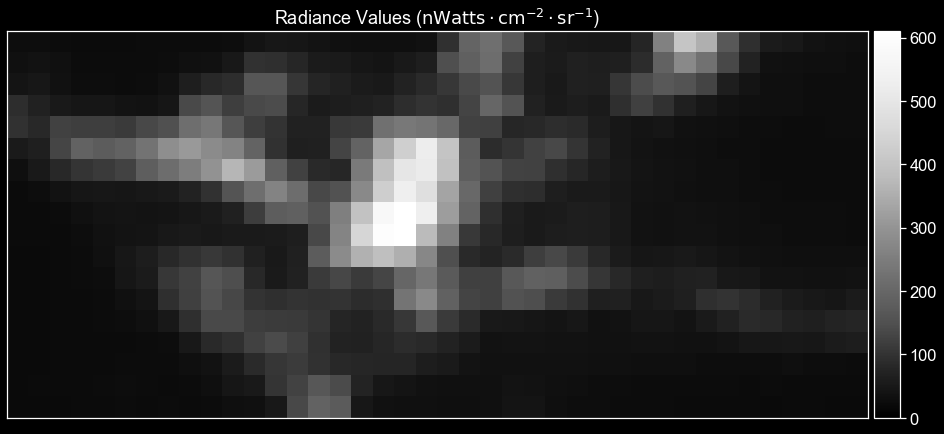

In [100]:
plot = plot_values(radiance_monthtly_mean.get('2019').get('09'), difference=False)

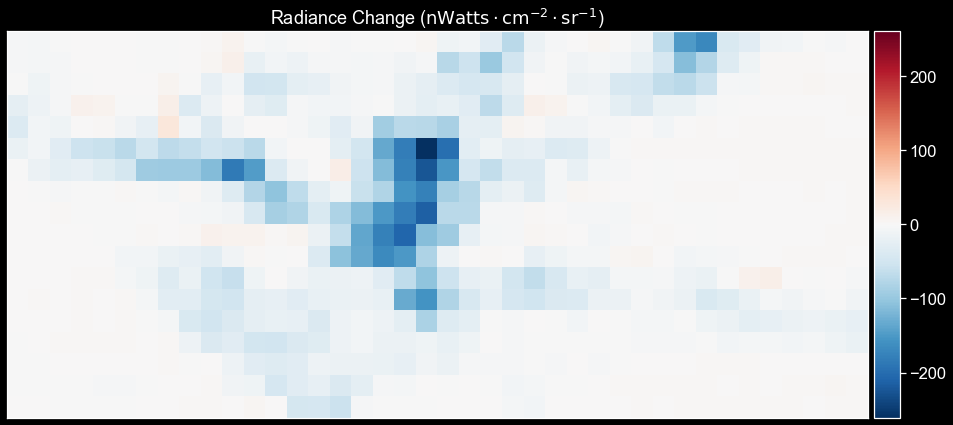

matplotlib.axes._subplots.AxesSubplot

In [101]:
plot = plot_values(diff_sep_2019_march_2020, difference=True)

type(plot)

#### Plot Differences from Baseline (Pre-COVID to COVID)

In [ ]:
# import numpy.ma as ma

# test = radiance_sept_2018_apr_2020.get('2019').get('09')

# # Count number of missing days
# for key in test.keys():
# #     print(test.get(key))
#     if np.isnan(np.sum(test.get(key))):
#         print(f"Sept {key} - Contains NaN - Missing Data")
# #     print(test.get(key)).count()
#     print(key, type(test.get(key)))
#     if isinstance(test.get(key), np.ma.core.MaskedArray):
#         print(key)
#         count = test.get(key).count()
#         print("Number of pixels masked (out of 720 total):", count)
        

# # Need to also count the number of fully masked arrays in month?

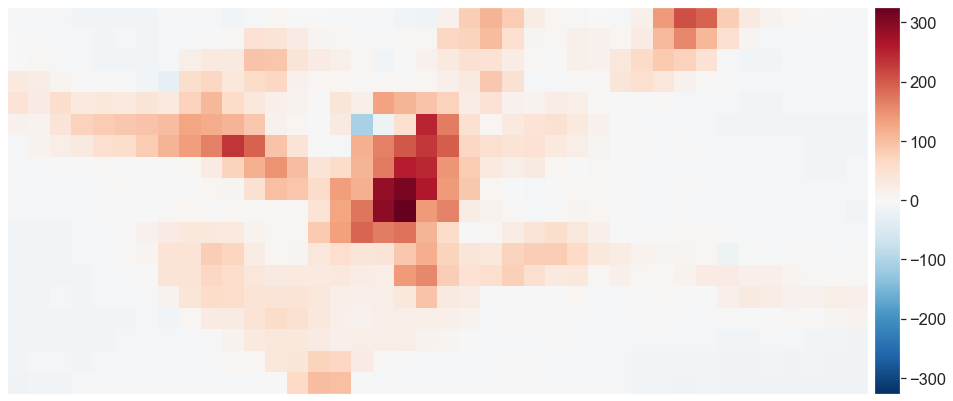

In [61]:
# Calculate September 2018 to September 2019 difference
diff_sep_2018_sep_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('09'),
    radiance_monthtly_mean.get('2018').get('09'))

# Plot difference from September 2018 to September 2019
ax = ep.plot_bands(
    diff_sep_2018_sep_2019, 
    scale=False, 
#     vmin=-200,
#     vmax=200,
    vmin=-diff_sep_2018_sep_2019.max(),
    vmax=diff_sep_2018_sep_2019.max(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

In [ ]:
# Calculate October 2018 to October 2019 difference
diff_oct_2018_oct_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('10'),
    radiance_monthtly_mean.get('2018').get('10'))

# Plot difference from October 2018 to October 2019 
ep.plot_bands(
    diff_oct_2018_oct_2019, 
    scale=False, 
    vmin=-200,
    vmax=200,
#     vmin=-diff_oct_2018_oct_2019.max(),
#     vmax=diff_oct_2018_oct_2019.max(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

In [ ]:
# Calculate November 2018 to November 2019 difference
diff_nov_2018_nov_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('11'),
    radiance_monthtly_mean.get('2018').get('11'))

# Plot difference from November 2018 to November 2019
ep.plot_bands(
    diff_nov_2018_nov_2019, 
    scale=False, 
#     vmin=-200,
#     vmax=200,
    vmin=-diff_nov_2018_nov_2019.max(),
    vmax=diff_nov_2018_nov_2019.max(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

In [ ]:
# Calculate December 2018 to December 2019 difference
diff_dec_2018_dec_2019 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2019').get('12'),
    radiance_monthtly_mean.get('2018').get('12'))

# Plot difference from December 2018 to December 2019
ep.plot_bands(
    diff_dec_2018_dec_2019, 
    scale=False, 
    vmin=-200,
    vmax=200,
#     vmin=diff_dec_2018_dec_2019.min(),
#     vmax=-diff_dec_2018_dec_2019.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

In [ ]:
# Calculate January 2019 to January 2020 difference
diff_jan_2019_jan_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('01'),
    radiance_monthtly_mean.get('2019').get('01'))

# Plot difference from January 2019 to January 2020
ep.plot_bands(
    diff_jan_2019_jan_2020, 
    scale=False, 
    vmin=diff_jan_2019_jan_2020.min(),
    vmax=-diff_jan_2019_jan_2020.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

In [ ]:
# Calculate February 2019 to February 2020 difference
diff_feb_2019_feb_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('02'),
    radiance_monthtly_mean.get('2019').get('02'))

# Plot difference from February 2019 to February 2020
ep.plot_bands(
    diff_feb_2019_feb_2020, 
    scale=False, 
    vmin=diff_feb_2019_feb_2020.min(),
    vmax=-diff_feb_2019_feb_2020.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

In [ ]:
# Calculate March 2019 to March 2020 difference
diff_march_2019_march_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('03'),
    radiance_monthtly_mean.get('2019').get('03'))

# Plot difference from March 2019 to March 2020
ep.plot_bands(
    diff_march_2019_march_2020, 
    scale=False, 
    vmin=diff_march_2019_march_2020.min(),
    vmax=-diff_march_2019_march_2020.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

In [ ]:
# Calculate April 2019 to April 2020 difference
diff_april_2019_april_2020 = rd.subtract_arrays(
    radiance_monthtly_mean.get('2020').get('04'),
    radiance_monthtly_mean.get('2019').get('04'))

# Plot difference from April 2019 to April 2020
ep.plot_bands(
    diff_april_2019_april_2020, 
    scale=False, 
    vmin=-200,
    vmax=200,
#     vmin=diff_april_2019_april_2020.min(),
#     vmax=-diff_april_2019_april_2020.min(),
    cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

### Calculate and Store Monthly Means (Alternative Version)

In [ ]:
# # Define date ranges to loop through
# date_ranges = [
#     rd.create_date_list('2019-09-01', '2019-09-30'),
#     rd.create_date_list('2019-10-01', '2019-10-31'),
#     rd.create_date_list('2019-11-01', '2019-11-30'),
#     rd.create_date_list('2019-12-01', '2019-12-31')
# ]

In [ ]:
# # Initialize dictionary to store monthly mean radiance arrays
# radiance_mean_dict = {}

# # Loop through all months
# for date_range in date_ranges:
    
#     # Create index based on date range
#     date_key = date_range[0].replace('-', '') + '-' + date_range[-1].replace('-', '')
    
#     # Get array for each date into list
#     radiance_arrays = rd.extract_data(
#         radiance=radiance_sept_2018_may_2020, dates=date_range)
    
#     # Calculate mean of arrays
#     radiance_mean = rd.calculate_mean(radiance_arrays)

#     # Add mean array to dictionary
#     if date_key not in radiance_mean_dict.keys():
#         radiance_mean_dict[date_key] = radiance_mean

In [ ]:
# Shows keys for date ranges in the dictionary
# radiance_mean_dict.keys()

### Plot Date Range Means

#### Continuous Date Ranges

In [ ]:
# Initialize dictionary to store monthly mean radiance arrays
radiance_sept_2018_may_2020_dict = {}

# Loop through all months
for date_range in date_ranges:
    
    # Create index based on date range
    date_key = date_range[0].replace('-', '') + '-' + date_range[-1].replace('-', '')
    
    # Get array for each date into list
    radiance_arrays = rd.extract_data(
        radiance=radiance_sept_2018_may_2020, dates=date_range)
    
    # Calculate mean of arrays
    radiance_mean = rd.calculate_mean(radiance_arrays)

    # Add mean array to dictionary
    if date_key not in radiance_sept_2018_may_2020_dict.keys():
        radiance_sept_2018_may_2020_dict[date_key] = radiance_mean

In [ ]:
# Show date ranges (key) in dictionary
for key in radiance_sept_2018_may_2020_dict.keys():
    print(f"Key: {key}, Shape: {radiance_sept_2018_may_2020_dict.get(key).shape}")

#### Plot Non-Continuous Date Ranges - Weekly Individual Days

In [53]:
# Get Spring 2019 Sunday and Spring 2020 Sunday mean
spring_2019_sunday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20190105-20190505-SUN')
spring_2020_sunday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20200111-20200510-SUN')

diff = spring_2020_sunday_mean - spring_2019_sunday_mean

# Plot radiance values
ep.plot_bands(
    diff,
    title="Mean Radiance Difference ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=-diff.max(),
    vmax=diff.max())


NameError: name 'radiance_weekly_fall_2018_spring_2020' is not defined

In [ ]:
# Get Spring 2019 Mondays and Spring 2020 Mondays mean
spring_2019_monday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20190105-20190505-MON')
spring_2020_monday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20200111-20200510-MON')

diff = spring_2020_monday_mean - spring_2019_monday_mean

# Plot radiance values
ep.plot_bands(
    diff,
    title="Mean Radiance Difference ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=diff.min(),
    vmax=-diff.min()
)


In [ ]:
# Get Spring 2019 Tue and Spring 2020 Tue mean
spring_2019_tuesday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20190105-20190505-TUE')
spring_2020_tuesday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20200111-20200510-TUE')

diff = spring_2020_tuesday_mean - spring_2019_tuesday_mean

# Plot radiance values
ep.plot_bands(
    diff,
    title="Mean Radiance Difference ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=diff.min(),
    vmax=-diff.min()
)


In [ ]:
# Get Spring 2019 Wedand Spring 2020 Wed mean
spring_2019_wednesday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20190105-20190505-WED')
spring_2020_wednesday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20200111-20200510-WED')

diff = spring_2020_wednesday_mean - spring_2019_wednesday_mean

# Plot radiance values
ep.plot_bands(
    diff,
    title="Mean Radiance Difference ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=diff.min(),
    vmax=-diff.min()
)


In [ ]:
# Get Spring 2019 Thurs and Spring 2020 Thurs mean
spring_2019_thursday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20190105-20190505-THU')
spring_2020_thursday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20200111-20200510-THU')

diff = spring_2020_thursday_mean - spring_2019_thursday_mean

# Plot radiance values
ep.plot_bands(
    diff,
    title="Mean Radiance Difference ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=diff.min(),
    vmax=-diff.min()
)


In [ ]:
# Get Spring 2019 Thurs and Spring 2020 Thurs mean
spring_2019_friday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20190105-20190505-FRI')
spring_2020_friday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20200111-20200510-FRI')

diff = spring_2020_friday_mean - spring_2019_friday_mean

# Plot radiance values
ep.plot_bands(
    diff,
    title="Mean Radiance Difference ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=-diff.max(),
    vmax=diff.max()
)


In [ ]:
# Get Spring 2019 Thurs and Spring 2020 Thurs mean
spring_2019_saturday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20190105-20190505-SAT')
spring_2020_saturday_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20200111-20200510-SAT')

diff = spring_2020_saturday_mean - spring_2019_saturday_mean

# Plot radiance values
ep.plot_bands(
    diff,
    title="Mean Radiance Difference ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=diff.min(),
    vmax=-diff.min()
)


#### Plot Non-Continuous Date Ranges - Weekly Business Days

In [ ]:
# Get Spring 2019 Sunday and Spring 2020 Sunday mean
spring_2019_business_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20190105-20190505-SUN')
spring_2020_business_mean = radiance_weekly_fall_2018_spring_2020.get(
    '20200111-20200510-SUN')

diff = spring_2020_business_mean - spring_2019_business_mean

# Plot radiance values
ep.plot_bands(
    diff,
    title="Mean Radiance Difference ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=-diff.max(),
    vmax=diff.max())


## Data Visualization

### Plot Cloud Free Mean Radiance Values for September 2019

In [ ]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot radiance values
ep.plot_bands(
    radiance_monthtly_mean.get('2019').get('09'),
    title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax,
    vmax=radiance_monthtly_mean.get('2019').get('09').max())

# Plot lat/lon (centroids)
# psu_lat_lon_gdf.plot(ax=ax)

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        sept_2019_radiance_mean,
        hist_range=(0, sept_2019_radiance_mean.max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (September 2019)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', 
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Mean Radiance Values for March 2020

In [ ]:
# Create figure and axes object
fig, ax = plt.subplots(figsize=(20, 10))

# Plot with extent
ep.plot_bands(
    radiance_monthtly_mean.get('2020').get('03'),
    title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
    #cmap='Greens_r',
    scale=False,
    extent=psu_extent, 
    ax=ax, 
    vmax=radiance_monthtly_mean.get('2020').get('03').max())

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        radiance_monthtly_mean.get('2020').get('03'),
        hist_range=(0, radiance_monthtly_mean.get('2019').get('09').max()),
        colors='#984ea3',
        title='Distribution of the Mean Radiance (March 2020)',
        xlabel='Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)',
        ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

    plt.show()

### Plot Cloud Free Change in Mean Radiance Values from September 2019 to March 2020

In [ ]:
diff_sept_2019_march_2020 = radiance_monthtly_mean.get('2020').get(
    '03') - radiance_monthtly_mean.get('2019').get('09')

# Plot change in radiance values
ep.plot_bands(
    diff_sept_2019_march_2020,
    title="Difference in Mean Radiance (March 2020 - September 2019)",
    cmap='RdBu_r',
    figsize=(20, 10),
    scale=False,
    vmin=diff_sept_2019_march_2020.min(),
    vmax=-diff_sept_2019_march_2020.min(),
    extent=psu_extent)

plt.show()

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        diff_sept_2019_march_2020,
        hist_range=(diff_sept_2019_march_2020.min(), -diff_sept_2019_march_2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

### Combined Plots

In [ ]:
# Plot
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(3, 1, figsize=(30, 20))

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(top=0.9)

    ep.plot_bands(
        radiance_monthtly_mean.get('2019').get('09'), title="September 2019 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=radiance_monthtly_mean.get('2019').get('09').max(),
        ax=ax[0],
        extent=psu_extent)

    ep.plot_bands(
        radiance_monthtly_mean.get('2020').get('03'), title="March 2020 Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        scale=False,
        vmax=radiance_monthtly_mean.get('2019').get('09').max(),
        ax=ax[1],
        extent=psu_extent)

    ep.plot_bands(
        diff_sept_2019_march_2020, title="Change in Mean Radiance (September 2019 vs. March 2020) ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)",
        cmap='RdBu_r',
        scale=False,
        vmin=diff_sept_2019_march_2020.min(),
        vmax=-diff_sept_2019_march_2020.min(),
        ax=ax[2],
        extent=psu_extent)

    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)
    
    ax[0].title.set_size(20)
    ax[1].title.set_size(20)
    ax[2].title.set_size(20)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-values.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        diff_sept_2019_march_2020,
        #         bins=40,
        hist_range=(diff_sept_2019_march_2020.min(), -diff_sept_2019_march_2020.min()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance (September 2019 vs. March 2020)',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus\nCloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)

plt.savefig(
    fname="penn-state-mean-radiance-change-sept2019-mar2020-histogram.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

## Data Export

In [ ]:
# Define export output paths
sept_2019_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-sept-2019.tif")

march_2020_radiance_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-march-2020.tif")

radiance_diff_outpath = os.path.join(
    working_directory, "04-graphics-outputs",
    "penn-state-campus-radiance-difference-sept-2019-march-2020.tif")

In [ ]:
# Define export metadata
psu_campus_metadata = rd.create_metadata(
    array=diff_sept_2019_march_2020, transform=psu_transform)

In [ ]:
# Export September 2019 radiance
rd.export_array(
    array=radiance_monthtly_mean.get('2019').get('09'),
    output_path=sept_2019_radiance_outpath,
    metadata=psu_campus_metadata)

# Export March 2020 radiance
rd.export_array(
    array=radiance_monthtly_mean.get('2020').get('03'),
    output_path=march_2020_radiance_outpath,
    metadata=psu_campus_metadata)

# Export radiance difference
rd.export_array(
    array=diff_sept_2019_march_2020,
    output_path=radiance_diff_outpath,
    metadata=psu_campus_metadata)

## Plotting Array with Cell Lat/Lon Points

In [ ]:
# Display geodataframe
psu_lat_lon_gdf.head()

In [ ]:
# Plot difference array with gdf (lat/lon coords are top-left corner of pixels)
fig, ax = plt.subplots(figsize=(20, 10))

ep.plot_bands(
    diff_sept_2019_march_2020,
    title="PSU Campus - Difference Sept 2019 to March 2020",
    cmap='RdBu_r',
    scale=False,
    vmin=diff_sept_2019_march_2020.min(), 
    vmax=-diff_sept_2019_march_2020.min(),
    extent=psu_extent, ax=ax)

psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=16)

plt.show()

# Older Work

## Data Processing

Workflow for storing data in dictionary:

* Define list of dates that for data that will be added to the dictionary
    * ```python
    date_list = get_date_list(
        start_date='2019-09-01', 
        end_date='2020-04-30')
    ```

* Store data in dictionary
    * ```python
    store_daily_radiance(
        filled_radiance_data, 
        filled_cloud_mask_data, 
        date_list)
    ```
    * For each date in the date list:
        * Finds the date in the dataframe based on column name
        * Creates a correctly formatted (shaped) array for that data (values and cloud mask)
        * Masks if cloud mask values are present
        * Adds year/month/day index to dictionary as key and masked array as value


Workflow for accessing/extracting data from dictionary:

    * Call individual day via dictionary index
        * dictionary[YYYY][MM][DD] (returns array)
        * 
        
    * Call one month of data
        * dictionary[YYYY][MM][DD] (returns dictionary of arrays, with days as keys.
        * To get a list, use flatten_month() function
        
    * Call intra or inter-month data
        * get_date_list()
        * get_array_data_from_dict()
        * calculate_mean_radiance()


    * Define list of dates that for data that will be added to the dictionary
    * ```python
        date_list = get_date_list(
        start_date='2019-09-01', 
        end_date='2020-04-30')
 ```

Crate function for plotting?

* Get


Get daily data into a dictionary, for retrieval several different aggregation levels:

* Daily
* Monthly 
* Ranges of dates (in-between months)

Where data is centrally stored and many functions can act upon that data to run calculations.

1. Read data to dataframes

2. Add missing values

3. Create date list for looping through to pull radiance data (values and cloud mask)
    * *get_date_list()*
    

4. Store daily data in dictionary
    * *store_daily_radiance()*
    * ```python
    radiance_dict['Year']['Month']['Day']
    ```


5. Access values
    * Directly from dictionary for single days
    * Directly from dictionary for whole month data (to then average)
    * With the function *get_array_data_from_dict()* and input dictionary and date list for cross-month date list and/or specialized date list (weekly on Sundays, etc.) (offsets and/or anchored offsets)
        * https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
        
        
Should also do functions/workflow for individual pixel-based time series.

### Calculate and Store Date Range Means

In [ ]:
# Define date ranges to loop through
date_ranges = [
    rd.create_date_list('2019-09-15', '2019-10-15'),
    rd.create_date_list('2019-12-02', '2019-12-21'),
    rd.create_date_list('2019-12-22', '2020-01-10'),
    rd.create_date_list('2020-01-11', '2020-01-30')
]

In [ ]:
# Initialize dictionary to store monthly mean radiance arrays
radiance_mean_dict = {}

# Loop through all months
for date_range in date_ranges:
    
    # Create index based on date range
    date_key = date_range[0].replace('-', '') + '-' + date_range[-1].replace('-', '')
    
    # Get array for each date into list
    radiance_arrays = rd.extract_data(
        radiance=radiance_sept_2018_may_2020, dates=date_range)
    
    # Calculate mean of arrays
    radiance_mean = rd.calculate_mean(radiance_arrays)

    # Add mean array to dictionary
    if date_key not in radiance_mean_dict.keys():
        radiance_mean_dict[date_key] = radiance_mean

In [ ]:
# Shows keys for date ranges in the dictionary
radiance_mean_dict.keys()

In [ ]:
# Plot time period 1
ep.plot_bands(
    radiance_mean_dict.get('20191222-20200110'), 
    scale=False, 
    vmin=0,
    vmax=radiance_mean_dict.get('20200111-20200130').max(),
    #cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

In [ ]:
# Plot time period 2
ep.plot_bands(
    radiance_mean_dict.get('20200111-20200130'), 
    scale=False, 
    vmin=0,
    vmax=radiance_mean_dict.get('20200111-20200130').max(),
    #cmap='RdBu_r',
    figsize=(16, 8))

plt.show()

In [ ]:
# Compute difference in time periods
diff = rd.subtract_arrays(
    radiance_mean_dict.get('20200111-20200130'), 
    radiance_mean_dict.get('20191222-20200110'))

with plt.style.context('dark_background'):
    
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot difference from Sept 2019 to March 2020
    ep.plot_bands(
        diff, 
        title="Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)\nDec 22, 2019 - Jan 10, 2020 vs. Jan 11, 2020 - Jan 30, 2020",
        scale=False, 
        vmin=-diff.max(),
        vmax=diff.max(),
        cmap='RdBu_r',
        ax=ax)
        #figsize=(16, 8))


    # Add caption
    fig.text(0.5, .1, "Data Source: NASA Black Marble",
             ha='center', fontsize=16)

    
plt.savefig(
    fname="penn-state-mean-radiance-change-after-dec-2019-grad.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
# Histogram
with plt.style.context('dark_background'):
    fig, ax = ep.hist(
        diff,
        hist_range=(-diff.max(), diff.max()),
        colors='#984ea3',
        title='Distribution of the Change in Mean Radiance\nDec 22, 2019 - Jan 10, 2020 vs. Jan 11, 2020 - Jan 30, 2020',
        xlabel='Change in Mean Radiance ($\mathrm{nWatts \cdot cm^{−2} \cdot sr^{−1}}$)', ylabel='Pixel Count')

    plt.suptitle("Penn State Campus Cloud Free Mean Radiance", size=24)

    # Add caption
    fig.text(0.5, .03, "Data Source: NASA Black Marble",
             ha='center', fontsize=14)
    
plt.savefig(
    fname="penn-state-mean-radiance-change-distribution-after-dec-2019-grad.png", 
    facecolor='k', dpi=300, transparent=True, bbox_inches='tight')

### Full Month - Mean (Alternative Version)

In [ ]:
# Get dates from Sept 01 - Sept 30
date_list = rd.create_date_list('2019-09-01', '2019-09-30')

In [ ]:
# Get array for each date into list
sept_01_sep_30_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [ ]:
# Confirm length
len(sept_01_sep_30_arrays)

In [ ]:
# Calculate mean
sept_01_sep_30_mean = rd.calculate_mean(sept_01_sep_30_arrays)

In [ ]:
# Get min and max values for mean
print(f"Min: {sept_01_sep_30_mean.min()}")
print(f"Max: {sept_01_sep_30_mean.max()}")

In [ ]:
# Plot
ep.plot_bands(sept_01_sep_30_mean, scale=False, vmax=sept_01_sep_30_mean.max())

plt.show()

### Intra-Month Range - Mean

In [ ]:
# Get dates from Sept 10 - Sept 20
date_list = rd.create_date_list('2019-09-10', '2019-09-20')

In [ ]:
# Get array for each date into list
sept_10_sep_20_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [ ]:
# Confirm length
len(sept_10_sep_20_arrays)

In [ ]:
# Calculate mean
sept_10_sep_20_mean = rd.calculate_mean(sept_10_sep_20_arrays)

In [ ]:
# Get min and max values for mean
print(f"Min: {sept_10_sep_20_mean.min()}")
print(f"Max: {sept_10_sep_20_mean.max()}")

In [ ]:
# Plot
ep.plot_bands(sept_10_sep_20_mean, scale=False, vmax=sept_10_sep_20_mean.max())

plt.show()

### Inter-Month Continuous Range - Mean

In [ ]:
# Get dates from Sept 15 - Oct 15
date_list = rd.create_date_list('2019-09-15', '2019-10-15')

In [ ]:
# Get array for each date into list
sept_15_oct_15_arrays = rd.extract_data(
    radiance=radiance_sept_2018_may_2020, dates=date_list)

In [ ]:
# Confirm length
len(sept_15_oct_15_arrays)

In [ ]:
# Calculate mean
sept_15_oct_15_mean = rd.calculate_mean(sept_15_oct_15_arrays)

In [ ]:
# Get min and max values for mean
print(f"Min: {sept_15_oct_15_mean.min()}")
print(f"Max: {sept_15_oct_15_mean.max()}")

In [ ]:
# Plot
ep.plot_bands(sept_15_oct_15_mean, scale=False, vmax=sept_15_oct_15_mean.max())

plt.show()

### Multiple Full Months - Mean

In [ ]:
# Get dates from Dec 01 2019 - Jan 31 2020
date_list = rd.create_date_list('2019-12-01', '2020-01-31')

In [ ]:
# Get array for each date into list
dec_2019_jan_2020_arrays = rd.extract_data(
    radiance=radiance_sept_2018_may_2020, dates=date_list)

In [ ]:
# Confirm length
len(dec_2019_jan_2020_arrays)

In [ ]:
# Calculate mean
dec_2019_jan_2020_mean = rd.calculate_mean(dec_2019_jan_2020_arrays)

In [ ]:
# Get min and max values for mean
print(f"Min: {dec_2019_jan_2020_mean.min()}")
print(f"Max: {dec_2019_jan_2020_mean.max()}")

In [ ]:
# Plot
ep.plot_bands(dec_2019_jan_2020_mean, scale=False, vmax=dec_2019_jan_2020_mean.max())

plt.show()

### Inter-Month (Every Specific Day) - Mean

Documentation for pandas *date_range*():

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets

Weekly:
* W-SUN - weekly frequency (Sundays). Same as ‘W’
* W-MON	- weekly frequency (Mondays)
* W-TUE - weekly frequency (Tuesdays)
* W-WED - weekly frequency (Wednesdays)
* W-THU - weekly frequency (Thursdays)
* W-FRI - weekly frequency (Fridays)
* W-SAT - weekly frequency (Saturdays)

#### Sundays

In [ ]:
# Get Sundays from Sept 2019 - April 2020
date_list = rd.create_date_list('2019-09-01', '2020-04-30', date_frequency='W-SUN')

In [ ]:
# Get array for each date into list
sept_2019_apr_2020_sundays_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [ ]:
# Confirm length
len(sept_2019_apr_2020_sundays_arrays)

In [ ]:
# Calculate mean
sept_2019_apr_2020_sundays_mean = rd.calculate_mean(
    sept_2019_apr_2020_sundays_arrays)

In [ ]:
# Get min and max values for mean
print(f"Min: {sept_2019_apr_2020_sundays_mean.min()}")
print(f"Max: {sept_2019_apr_2020_sundays_mean.max()}")

In [ ]:
# Plot
ep.plot_bands(sept_2019_apr_2020_sundays_mean, scale=False,
              vmax=sept_2019_apr_2020_sundays_mean.max())

plt.show()

#### Mondays

In [ ]:
# Get Mondays from Sept 2019 - April 2020
date_list = rd.create_date_list(
    '2019-09-01', '2020-04-30', date_frequency='W-MON')

In [ ]:
# Get array for each date into list
sept_2019_apr_2020_mondays_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [ ]:
# Confirm length
len(sept_2019_apr_2020_mondays_arrays)

In [ ]:
# Calculate mean
sept_2019_apr_2020_mondays_mean = rd.calculate_mean(
    sept_2019_apr_2020_mondays_arrays)

In [ ]:
# Get min and max values for mean
print(f"Min: {sept_2019_apr_2020_mondays_mean.min()}")
print(f"Max: {sept_2019_apr_2020_mondays_mean.max()}")

In [ ]:
# Plot
ep.plot_bands(sept_2019_apr_2020_mondays_mean, scale=False,
              vmax=sept_2019_apr_2020_mondays_mean.max())

plt.show()

#### Business Days

In [ ]:
# Get business days, March 2020
date_list = rd.create_date_list('2020-03-01', '2020-03-14', date_frequency='B')

In [ ]:
# Get array for each date into list
march_2020_business_arrays = rd.extract_data(
 radiance=radiance_sept_2018_may_2020, dates=date_list)

In [ ]:
# Confirm length
len(march_2020_business_arrays)

In [ ]:
# Calculate mean
march_2020_business_mean = rd.calculate_mean(march_2020_business_arrays)

In [ ]:
# Get min and max values for mean
print(f"Min: {march_2020_business_mean.min()}")
print(f"Max: {march_2020_business_mean.max()}")

In [ ]:
# Plot
ep.plot_bands(march_2020_business_mean, scale=False,
              vmax=march_2020_business_mean.max())

plt.show()

## Plotting Array with Lat/Lon

#### Centroids

In [ ]:
# # # Lat/lon is CENTER of pixel
# # Define extent
# psu_extent = (
#     lon_min - coord_spacing/2,
#     lon_max + coord_spacing/2,
#     lat_min - coord_spacing/2,
#     lat_max + coord_spacing/2
# )

# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot with extent
# ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
#               #cmap='Greens_r',
#               #cmap='RdYlBu_r',
#               #cmap='coolwarm',
#               cmap='RdBu_r',
#               #figsize=(20,10),
#               scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
#               extent=psu_extent, ax=ax)#, vmax=1000)

# psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# # ax.set_axis_on()

# plt.show()

In [ ]:
# # Lat/lon is TOP-RIGHT corner of pixel
# psu_extent = (
#     lon_min - coord_spacing,
#     lon_max, # + coord_spacing,
#     lat_min - coord_spacing,
#     lat_max# + coord_spacing
# )
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot with extent
# ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
#               #cmap='Greens_r',
#               #cmap='RdYlBu_r',
#               #cmap='coolwarm',
#               cmap='RdBu_r',
#               #figsize=(20,10),
#               scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
#               extent=psu_extent, ax=ax)#, vmax=1000)

# psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# # ax.set_axis_on()

# plt.show()

In [ ]:
# # Lat/lon is BOTTOM-RIGHT corner of pixel
# psu_extent = (
#     lon_min - coord_spacing,
#     lon_max, # + coord_spacing,
#     lat_min, # - coord_spacing,
#     lat_max + coord_spacing
# )
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot with extent
# ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
#               #cmap='Greens_r',
#               #cmap='RdYlBu_r',
#               #cmap='coolwarm',
#               cmap='RdBu_r',
#               #figsize=(20,10),
#               scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
#               extent=psu_extent, ax=ax)#, vmax=1000)

# psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# # ax.set_axis_on()

# plt.show()

In [ ]:
# # Lat/lon is BOTTOM-LEFT corner of pixel
# psu_extent = (
#     lon_min, # - coord_spacing,
#     lon_max + coord_spacing,
#     lat_min, # - coord_spacing,
#     lat_max + coord_spacing
# )
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot with extent
# ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
#               #cmap='Greens_r',
#               #cmap='RdYlBu_r',
#               #cmap='coolwarm',
#               cmap='RdBu_r',
#               #figsize=(20,10),
#               scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
#               extent=psu_extent, ax=ax)#, vmax=1000)

# psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# # ax.set_axis_on()

# plt.show()

### Non-Rounded Coord Spacing

In [ ]:
# # # Lat/lon is CENTER of pixel
# # Define extent
# psu_extent = (
#     lon_min - lon_spacing/2,
#     lon_max + lon_spacing/2,
#     lat_min - lat_spacing/2,
#     lat_max + lat_spacing/2
# )

# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot with extent
# ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
#               #cmap='Greens_r',
#               #cmap='RdYlBu_r',
#               #cmap='coolwarm',
#               cmap='RdBu_r',
#               #figsize=(20,10),
#               scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
#               extent=psu_extent, ax=ax)#, vmax=1000)

# psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# # ax.set_axis_on()

# plt.show()

In [ ]:
# # Lat/lon is TOP-LEFT corner of pixel
# psu_extent = (
#     lon_min, # - coord_spacing,
#     lon_max + lon_spacing,
#     lat_min - lat_spacing,
#     lat_max# + coord_spacing
# )
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot with extent
# ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
#               #cmap='Greens_r',
#               #cmap='RdYlBu_r',
#               #cmap='coolwarm',
#               cmap='RdBu_r',
#               #figsize=(20,10),
#               scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
#               extent=psu_extent, ax=ax)#, vmax=1000)

# psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# # ax.set_axis_on()

# plt.show()

In [ ]:
# # Lat/lon is TOP-RIGHT corner of pixel
# psu_extent = (
#     lon_min - lon_spacing,
#     lon_max, # + coord_spacing,
#     lat_min - lat_spacing,
#     lat_max# + coord_spacing
# )
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot with extent
# ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
#               #cmap='Greens_r',
#               #cmap='RdYlBu_r',
#               #cmap='coolwarm',
#               cmap='RdBu_r',
#               #figsize=(20,10),
#               scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
#               extent=psu_extent, ax=ax)#, vmax=1000)

# psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# # ax.set_axis_on()

# plt.show()

In [ ]:
# # Lat/lon is BOTTOM-RIGHT corner of pixel
# psu_extent = (
#     lon_min - lon_spacing,
#     lon_max, # + coord_spacing,
#     lat_min, # - coord_spacing,
#     lat_max + lat_spacing
# )
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot with extent
# ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
#               #cmap='Greens_r',
#               #cmap='RdYlBu_r',
#               #cmap='coolwarm',
#               cmap='RdBu_r',
#               #figsize=(20,10),
#               scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
#               extent=psu_extent, ax=ax)#, vmax=1000)

# psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# # ax.set_axis_on()

# plt.show()

In [ ]:
# # Lat/lon is BOTTOM-LEFT corner of pixel
# psu_extent = (
#     lon_min, # - coord_spacing,
#     lon_max + lon_spacing,
#     lat_min, # - coord_spacing,
#     lat_max + lat_spacing
# )
# fig, ax = plt.subplots(figsize=(20, 10))

# # Plot with extent
# ep.plot_bands(diff_sept_2019_march_2020, title="PSU Campus - Difference Sept 2019 to March 2020", 
#               #cmap='Greens_r',
#               #cmap='RdYlBu_r',
#               #cmap='coolwarm',
#               cmap='RdBu_r',
#               #figsize=(20,10),
#               scale=False, vmin=diff_sept_2019_march_2020.min(), vmax=-diff_sept_2019_march_2020.min(),
#               extent=psu_extent, ax=ax)#, vmax=1000)

# psu_lat_lon_gdf.plot(ax=ax, color='black', markersize=9)

# # ax.set_axis_on()

# plt.show()